In [110]:
#@title [RUN] Install required libraries

!pip install pyg_lib torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-geometric
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [111]:
#@title [RUN] Import modules

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import torch

from torch import Tensor
from torch.nn import CrossEntropyLoss, Module, ModuleList, Parameter
from torch.nn.functional import relu
from torch.nn.utils.parametrize import register_parametrization
from torch_geometric.datasets import HeterophilousGraphDataset, MixHopSyntheticDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, MLP
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import glorot
from torch_geometric.nn.resolver import activation_resolver
from torch_geometric.typing import Adj, OptPairTensor, OptTensor, SparseTensor
from torch_geometric.utils import homophily, spmm
from torchinfo import summary
from typing import Any, Callable, Dict, List, Optional, Type, Union

In [112]:
#@title [RUN] Ensure reproducibility

def ensure_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

ensure_reproducibility(1337)

In [113]:
#@title [RUN] Define model classes

class SymmetricLinear(Linear):
    class Symmetric(Module):
        def forward(self, x):
            return x.triu() + x.triu(1).transpose(-1, -2)

    def __init__(self, channels):
        super().__init__(channels, channels, bias=False, weight_initializer='glorot')
        register_parametrization(self, 'weight', self.Symmetric())


class GRAFFNN(Module):
    def __init__(self, num_layers: int, in_channels: int, out_channels: int, hidden_channels: int,
                 act: Union[str, Callable, None] = "relu", act_kwargs: Optional[Dict[str, Any]] = None,
                 shared_weights: bool = True, step_size: int = 1):
        super().__init__()
        self.act = activation_resolver(act, **(act_kwargs or {}))
        self.encoder = MLP([in_channels, hidden_channels])
        self.decoder = MLP([hidden_channels, out_channels])
        channel_mixers = (
            SymmetricLinear(hidden_channels),
            SymmetricLinear(hidden_channels)
        ) if shared_weights else None
        self.graff_convs = ModuleList([GRAFFConv(channels=hidden_channels, 
                                                 channel_mixers=channel_mixers,
                                                 step_size=step_size)
                                       for _ in range(num_layers)])

    def forward(self, data):
        x_0 = self.encoder(data.x)
        x = x_0
        for graff_conv in self.graff_convs:
            x = graff_conv(x, x_0, data.edge_index)
            if self.act is not None:
                x = self.act(x)
        return self.decoder(x)


class GRAFFConv(MessagePassing):
    _cached_edge_index: Optional[OptPairTensor]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(self, channels: int, channel_mixers: Optional[tuple[SymmetricLinear]] = None, step_size: int = 1,
                       cached: bool = False, add_self_loops: bool = True, normalize: bool = True, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)

        self.channels = channels
        self.step_size = step_size
        self.cached = cached
        self.add_self_loops = add_self_loops
        self.normalize = normalize
        self.has_own_weights = channel_mixers is None
        if self.has_own_weights:
            self.internal_mixer = SymmetricLinear(channels)
            self.external_mixer = SymmetricLinear(channels)
        else:
            if not isinstance(channel_mixers, tuple) or len(channel_mixers) != 2:
                raise ValueError("Argument channel_mixers must be tuple of length 2")
            self.internal_mixer, self.external_mixer = channel_mixers
        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        if self.has_own_weights:
            self.internal_mixer.reset_parameters()
            self.external_mixer.reset_parameters()
        self._cached_edge_index = None
        self._cached_adj_t = None

    def forward(self, x: Tensor, x_0: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        if self.normalize:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gcn_norm(
                        edge_index, edge_weight, x.size(self.node_dim), False,
                        self.add_self_loops, self.flow, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gcn_norm(
                        edge_index, edge_weight, x.size(self.node_dim), False,
                        self.add_self_loops, self.flow, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        internal_repr = self.propagate(edge_index, x=self.internal_mixer(x), edge_weight=edge_weight)
        return x + self.step_size * (internal_repr - self.external_mixer(x))

    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return spmm(adj_t, x, reduce=self.aggr)

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}({self.channels})'


class GCN(Module):
    def __init__(self, num_layers: int, in_channels: int, out_channels: int, hidden_channels: int):
        super().__init__()
        self.convs = ModuleList([GCNConv(in_channels, hidden_channels) if i == 0
                                 else GCNConv(hidden_channels, out_channels) if i == num_layers
                                 else GCNConv(hidden_channels, hidden_channels)
                                 for i in range(num_layers + 1) ])

    def forward(self, data):
        x = data.x
        for layer in self.convs[:-1]:
            x = relu(layer(x, data.edge_index))
        return self.convs[-1](x, data.edge_index)

In [114]:
#@title [RUN] Define training procedure

def train(model, dataset, *, learning_rate, num_epochs, verbose):
    if verbose:
        print(summary(model, depth=2))

    data = dataset[0]
    if len(data.train_mask.shape) > 1:
        data.train_mask = data.train_mask[:, 0]
        data.val_mask = data.val_mask[:, 0]
        data.test_mask = data.test_mask[:, 0]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    data.x = data.x.to(device)
    data.y = data.y.to(device)

    criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    def accuracy(pred, y, mask):
        return (pred[mask].argmax(dim=1) == y[mask]).sum().float() / mask.sum()

    best_acc_val = 0
    best_acc_test = 0

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        acc_val = accuracy(pred, data.y, data.val_mask)
        acc_test = accuracy(pred, data.y, data.test_mask)
        if acc_val > best_acc_val:
            best_acc_val = acc_val
            best_acc_test = acc_test
            if verbose:
                print(f'[Epoch {epoch+1}/{num_epochs}] Loss: {loss:.5f} | Val: {acc_val:.3f} | Test: {acc_test:.3f}')

    return best_acc_val, best_acc_test

In [115]:
#@title [RUN] Load datasets and print basic info

synthetic_datasets = {i/10: MixHopSyntheticDataset("MixHop", homophily=i/10) for i in range(10)}
real_datasets = {name: HeterophilousGraphDataset(root=".", name=name) 
                 for name in ["Roman-empire", "Amazon-ratings", "Tolokers", "Minesweeper", "Questions"]}

for name, dataset in (synthetic_datasets | real_datasets).items():
    data = dataset[0]
    print(10 * "=", name, 10 * "=")
    print("# graphs:", len(dataset))
    print("# nodes:", data.num_nodes)
    print("# edges:", data.num_edges)
    print("# node features:", dataset.num_node_features)
    print("# edge features:", dataset.num_edge_features)
    print("# classes:", dataset.num_classes)
    print("# train nodes:", data.train_mask.sum(dim=0).tolist())
    print("# eval nodes:", data.val_mask.sum(dim=0).tolist())
    print("# test nodes:", data.test_mask.sum(dim=0).tolist())
    print("undirected graph?:", data.is_undirected())
    print("isolated nodes?", data.has_isolated_nodes())
    print("self-loops?", data.has_self_loops())
    print("valid?", data.validate())
    print("homophily:", f"{homophily(data.edge_index, data.y):.2f}")

========== 0.0 ==========
# graphs: 1
# nodes: 5000
# edges: 59596
# node features: 2
# edge features: 0
# classes: 10
# train nodes: 1666
# eval nodes: 1666
# test nodes: 1668
undirected graph?: True
isolated nodes? True
self-loops? False
valid? True
homophily: 0.00
========== 0.1 ==========
# graphs: 1
# nodes: 5000
# edges: 59596
# node features: 2
# edge features: 0
# classes: 10
# train nodes: 1666
# eval nodes: 1666
# test nodes: 1668
undirected graph?: True
isolated nodes? True
self-loops? False
valid? True
homophily: 0.10
========== 0.2 ==========
# graphs: 1
# nodes: 5000
# edges: 59596
# node features: 2
# edge features: 0
# classes: 10
# train nodes: 1666
# eval nodes: 1666
# test nodes: 1668
undirected graph?: True
isolated nodes? True
self-loops? False
valid? True
homophily: 0.20
========== 0.3 ==========
# graphs: 1
# nodes: 5000
# edges: 59596
# node features: 2
# edge features: 0
# classes: 10
# train nodes: 1666
# eval nodes: 1666
# test nodes: 1668
undirected graph?: 

In [141]:
#@title Choose hyperparameters
DATASET_COLLECTION = "synthetic_datasets" #@param ["synthetic_datasets", "real_datasets"]
NUM_LAYERS = 10  #@param {type:"integer"}
HIDDEN_CHANNELS = 64  #@param {type:"integer"}
STEP_SIZE = 1  #@param {type:"number"}
ACTIVATION_FUNCTION = None  #@param {type:"raw"}
SHARED_WEIGHTS = True  #@param {type:"boolean"}
NUM_EPOCHS = 100  #@param {type:"integer"}
LEARNING_RATE = 0.01  #@param {type:"number"}

In [142]:
#@title Run experiment

gcn_accs = {}
graffnn_accs = {}
graffnn_eigvals = {}

for name, dataset in eval(DATASET_COLLECTION).items():
    print("Training on", name)
    gcn = GCN(num_layers=NUM_LAYERS, 
              hidden_channels=HIDDEN_CHANNELS,
              in_channels=dataset.num_features,
              out_channels=dataset.num_classes)
    graffnn = GRAFFNN(num_layers=NUM_LAYERS, 
                      hidden_channels=HIDDEN_CHANNELS,
                      in_channels=dataset.num_features,
                      out_channels=dataset.num_classes,
                      act=ACTIVATION_FUNCTION,
                      shared_weights=SHARED_WEIGHTS,
                      step_size=STEP_SIZE)

    gcn_accs[name] = train(gcn, dataset,
                           learning_rate=LEARNING_RATE, num_epochs=NUM_EPOCHS, verbose=False)
    graffnn_accs[name] = train(graffnn, dataset,
                               learning_rate=LEARNING_RATE, num_epochs=NUM_EPOCHS, verbose=False)
    graffnn_eigvals[name] = torch.linalg.eig(graffnn.graff_convs[0].internal_mixer.weight.detach())[0].real.sort()[0]

Training on 0.0
Training on 0.1
Training on 0.2
Training on 0.3
Training on 0.4
Training on 0.5
Training on 0.6
Training on 0.7
Training on 0.8
Training on 0.9


In [143]:
#@title GraFF-NN accuracies
for name, (acc_val, acc_test) in graffnn_accs.items():
    print(f"[{name}] Val: {acc_val:.3f} | Test: {acc_test:.3f}")

[0.0] Val: 0.510 | Test: 0.490
[0.1] Val: 0.534 | Test: 0.507
[0.2] Val: 0.577 | Test: 0.560
[0.3] Val: 0.656 | Test: 0.592
[0.4] Val: 0.677 | Test: 0.658
[0.5] Val: 0.745 | Test: 0.714
[0.6] Val: 0.836 | Test: 0.803
[0.7] Val: 0.889 | Test: 0.861
[0.8] Val: 0.949 | Test: 0.921
[0.9] Val: 0.981 | Test: 0.957


In [144]:
#@title GCN accuracies
for name, (acc_val, acc_test) in gcn_accs.items():
    print(f"[{name}] Val: {acc_val:.3f} | Test: {acc_test:.3f}")

[0.0] Val: 0.113 | Test: 0.092
[0.1] Val: 0.139 | Test: 0.163
[0.2] Val: 0.186 | Test: 0.169
[0.3] Val: 0.209 | Test: 0.209
[0.4] Val: 0.274 | Test: 0.230
[0.5] Val: 0.286 | Test: 0.305
[0.6] Val: 0.379 | Test: 0.356
[0.7] Val: 0.861 | Test: 0.833
[0.8] Val: 0.977 | Test: 0.964
[0.9] Val: 0.984 | Test: 0.980


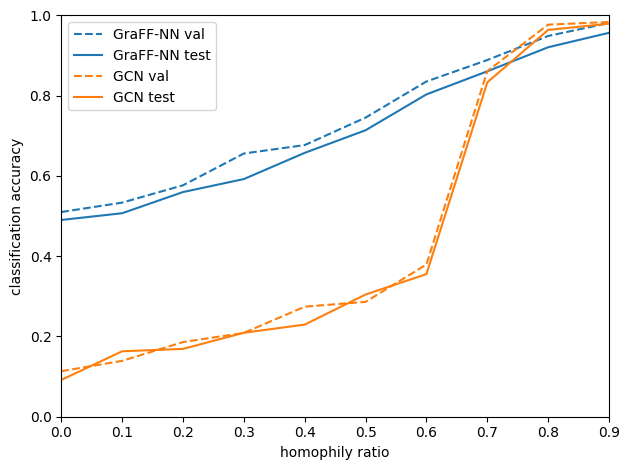

In [145]:
#@title Plot accuracies
graffnn_acc_val, graffnn_acc_test = list(zip(*list(graffnn_accs.values())))
p = plt.plot(graffnn_accs.keys(), graffnn_acc_val, "--", label="GraFF-NN val")
plt.plot(graffnn_accs.keys(), graffnn_acc_test, "-", label="GraFF-NN test", color=p[0].get_color())
gcn_acc_val, gcn_acc_test = list(zip(*list(gcn_accs.values())))
p = plt.plot(graffnn_accs.keys(), gcn_acc_val, "--", label="GCN val")
plt.plot(graffnn_accs.keys(), gcn_acc_test, "-", label="GCN test", color=p[0].get_color())
plt.xticks(rotation=20 if DATASET_COLLECTION == "real_datasets" else 0)
plt.xlabel("homophily ratio" if DATASET_COLLECTION == "synthetic_datasets" else "")
plt.ylabel("classification accuracy")
if DATASET_COLLECTION == "synthetic_datasets":
    plt.xlim((0, 0.9))
plt.ylim((0, 1))
plt.legend()
plt.tight_layout()
plt.savefig(f"accuracy_{DATASET_COLLECTION}.pdf")
plt.show()

In [146]:
#@title GraFF-NN eigenvalue stats
for name, eigval in graffnn_eigvals.items():
    print(10 * "=", name, 10 * "=")
    print(f"mean eigval: {eigval.mean().item():.3f}")
    print(f"std eigval: {eigval.std().item():.3f}")
    print(f"min eigval: {eigval.min().item():.3f}")
    print(f"max eigval: {eigval.max().item():.3f}")
    print("# neg eigval:", (eigval <= -1e-10).sum().item())
    print("# pos eigval:", (eigval >= 1e-10).sum().item())

========== 0.0 ==========
mean eigval: -0.086
std eigval: 0.969
min eigval: -2.113
max eigval: 1.713
# neg eigval: 34
# pos eigval: 30
========== 0.1 ==========
mean eigval: -0.074
std eigval: 1.015
min eigval: -2.357
max eigval: 1.792
# neg eigval: 33
# pos eigval: 31
========== 0.2 ==========
mean eigval: -0.096
std eigval: 0.989
min eigval: -1.958
max eigval: 1.658
# neg eigval: 34
# pos eigval: 30
========== 0.3 ==========
mean eigval: -0.099
std eigval: 1.004
min eigval: -1.980
max eigval: 1.786
# neg eigval: 34
# pos eigval: 30
========== 0.4 ==========
mean eigval: -0.056
std eigval: 0.998
min eigval: -2.093
max eigval: 1.700
# neg eigval: 33
# pos eigval: 31
========== 0.5 ==========
mean eigval: -0.076
std eigval: 1.008
min eigval: -2.228
max eigval: 1.823
# neg eigval: 34
# pos eigval: 30
========== 0.6 ==========
mean eigval: -0.090
std eigval: 0.998
min eigval: -1.966
max eigval: 1.785
# neg eigval: 35
# pos eigval: 29
========== 0.7 ==========
mean eigval: -0.097
std eigva

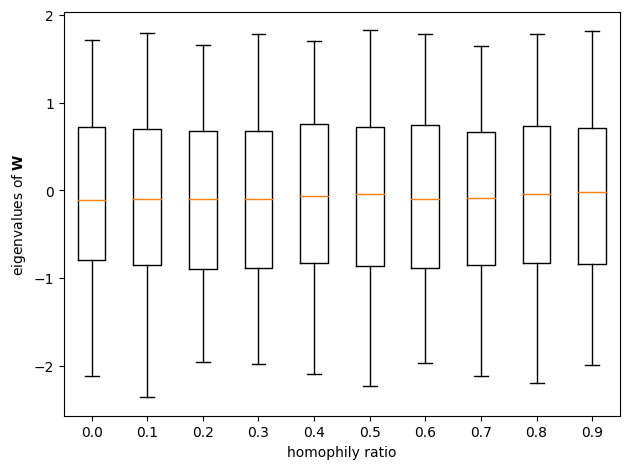

In [147]:
#@title Boxplot of GraFF-NN eigenvalues
plt.boxplot(graffnn_eigvals.values(), labels=graffnn_eigvals.keys())
plt.xticks(rotation=20 if DATASET_COLLECTION == "real_datasets" else 0)
plt.xlabel("homophily ratio" if DATASET_COLLECTION == "synthetic_datasets" else "")
plt.ylabel("eigenvalues of $\mathbf{W}$")
plt.tight_layout()
plt.savefig(f"eigvals_{DATASET_COLLECTION}.pdf")
plt.show()